# About

`dive` is a Python package for analyzing DEER spectroscopy with Bayesian inference. When given a model, prior distributions for each parameter (which are already included in dive), and experimental data, Markov chain Monte Carlo (MCMC) sampling is run with `PyMC` to yield refined posterior distributions for each parameter. The process is summarized in the figure below:

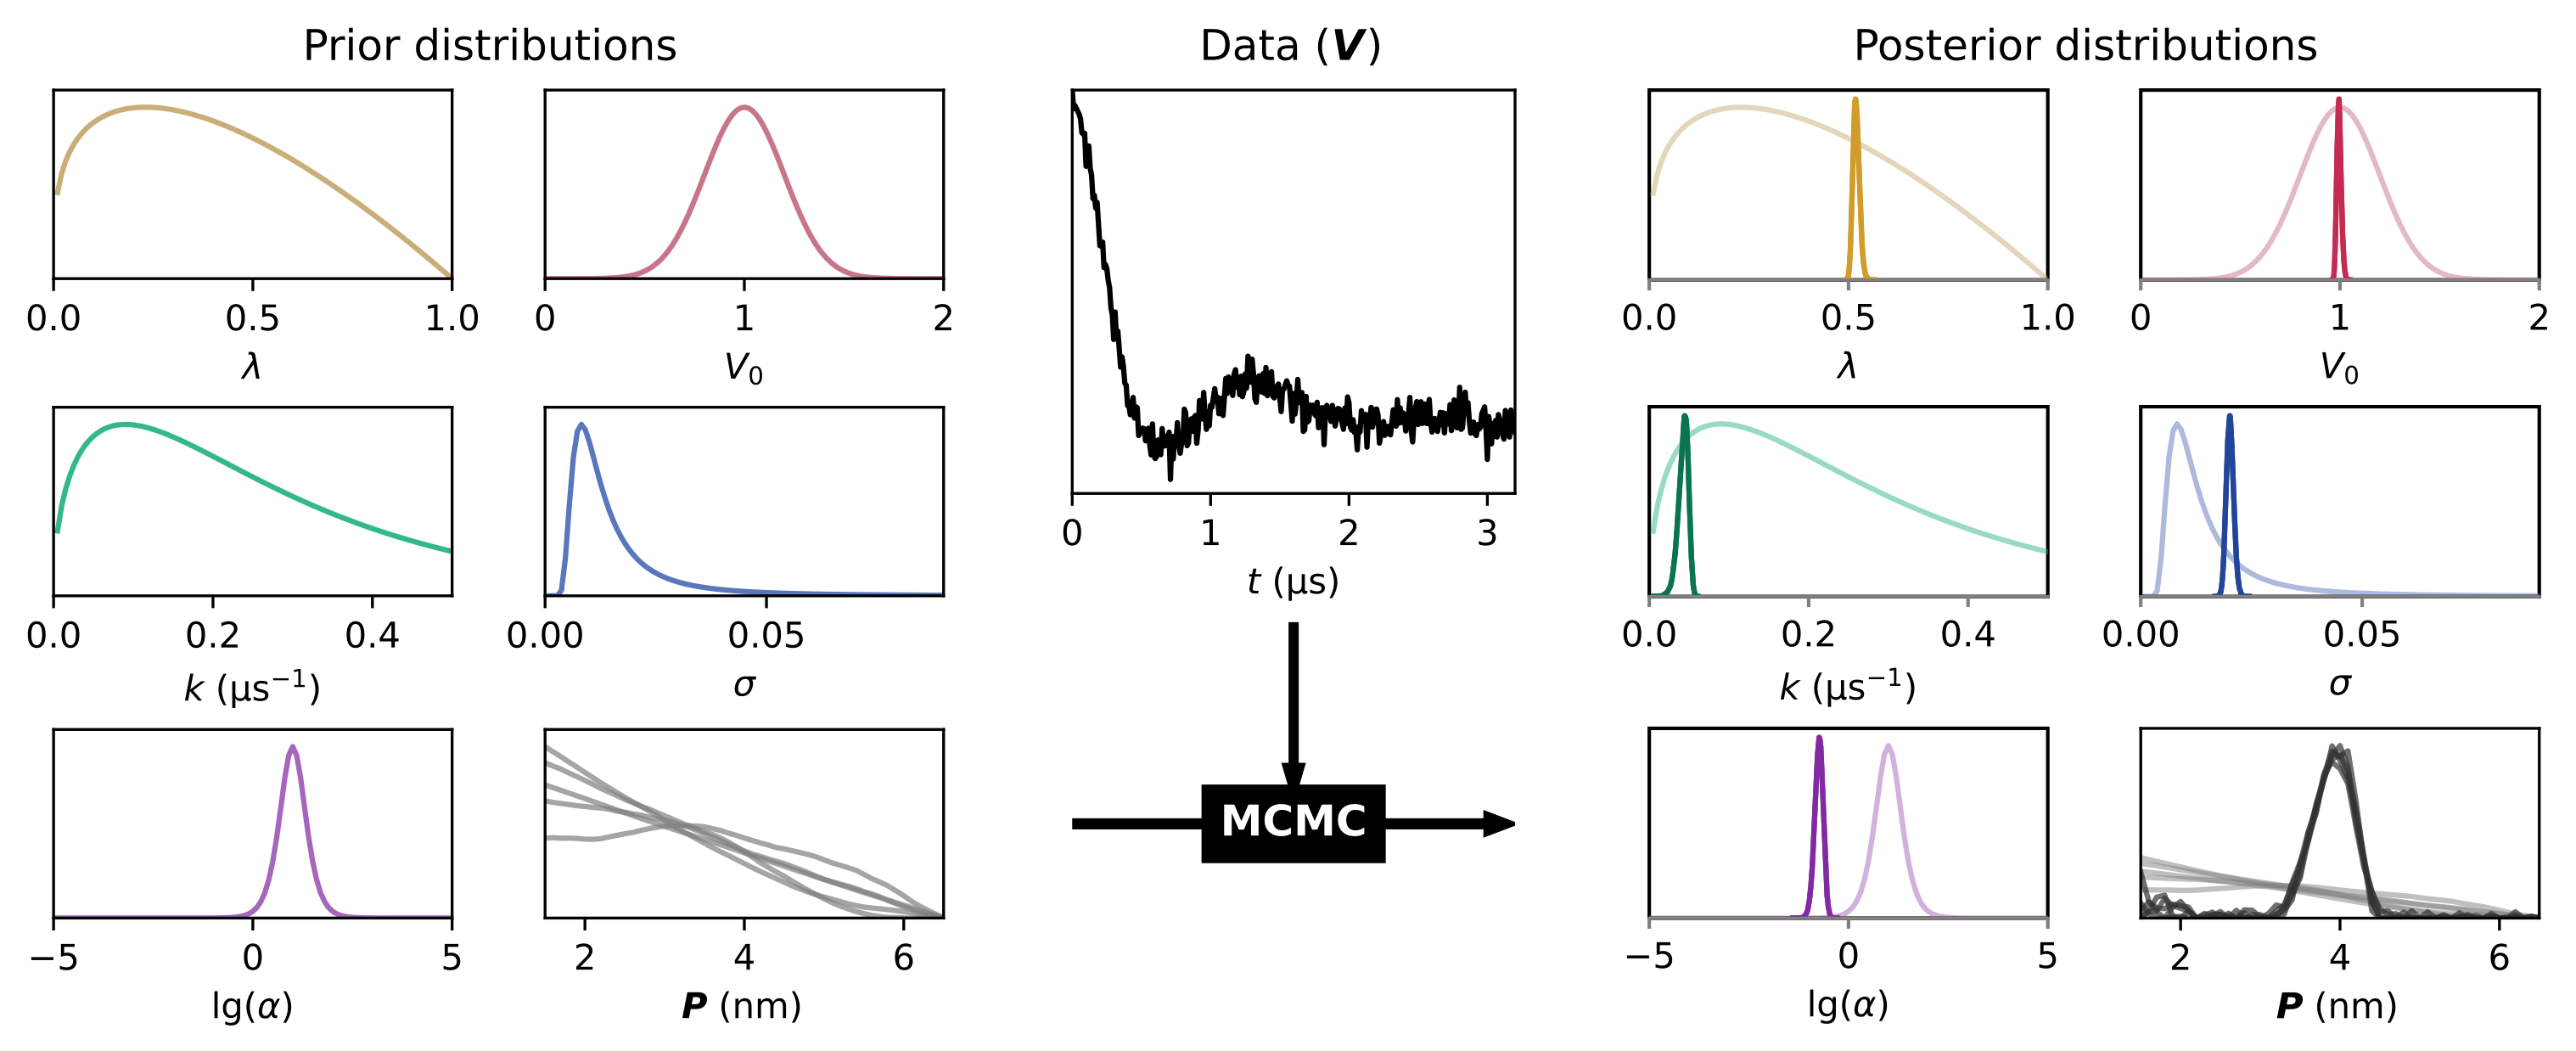

The posterior distributions on the right provide full quantification for the uncertainty of all parameters, and can be analyzed for their mean, confidence intervals, etc. This guide will provide a walkthrough on analyzing a DEER trace with `dive`.

# Installation & Setup

Install `dive` with pip. Please note that the installation name is `dive-MCMC`.

In [ ]:
!pip install dive-MCMC

Alternatively, download or clone `dive` from [GitHub](https://github.com/StollLab/dive) and install the necessary packages.

In [1]:
!git clone https://github.com/stolllab/dive

Cloning into 'dive'...
remote: Enumerating objects: 1657, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 1657 (delta 333), reused 294 (delta 227), pack-reused 1199
Receiving objects: 100% (1657/1657), 1.34 GiB | 25.56 MiB/s, done.
Resolving deltas: 100% (1087/1087), done.


In [2]:
!pip install pymc deerlab scipy matplotlib pandas mkl-service h5netcdf pytest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.2/508.2 kB 28.3 MB/s eta 0:00:00
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50453 sha256=0ef120143fbf41cf858fcf88d0c052b6c89ddb08109800a1efd0ca6be803e8e1
  Stored in directory: /root/.cache/pip/wheels/3e/b8/c5/b553d5e8b0249bd2859b3b6d7bb2a1849e7b01c6e8b64f6e87
Successfully built memoization


Lastly, please import the following packages, as they will be used frequently below.

In [5]:
import dive
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import deerlab as dl
from scipy.io import loadmat

# Reading Data

If you already have experimental traces that you wish to analyze, load them in as usual. Two example data files, `3992_good.dat` and `3992_bad.dat`, are also included with `dive` in the `/data` folder.

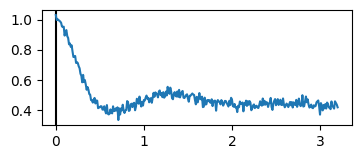

In [6]:
# example data in /data
loaded_data = np.genfromtxt(f"data/3992_good.dat", skip_header=1, delimiter=',')
t = loaded_data[:,0]
Vexp = loaded_data[:,1]

fig, ax = plt.subplots(figsize=(4,1.5))
ax.axvline(0,color="black")
ax.plot(t,Vexp)

**Important Note:** Please ensure that the peak of the trace is at t=0. If it is not, adjust your t-axis accordingly.

If you instead wish to create a simulated trace to analyze, please follow [this tutorial](https://jeschkelab.github.io/DeerLab/auto_examples/basic_simulations/ex_simulate_basic_4pdeer.html) from DeerLab. `dive` also contains the functions `generate_single_gauss` and `generate_multi_gauss` with similar functionality.

# Modeling

A model can be created in `dive` by

---

running `dive.model(t,Vexp,...)`. This model is needed for `PyMC` to perform numerical sampling.

Other important parameters for `dive.model` include:

- *`method="regularization"`*: The type of model to use. Accepts `"regularization"` (nonparametric Tikhonov regularization; default), `"regularization_NUTS"` (same as `"regularization"` using NUTS sampling for all variables; not recommended), or `"gaussian"` (gaussian mixture model for P(r)).

- *`r=None`*: The distance axis for the fitted distance distribution. Using `np.linspace()` with 50-100 evenly-spaced points is recommended. Ensure that the lower and upper bounds are reasonable; larger upper bounds will run much more slowly and sample much less efficiently. If not provided, an r-axis will be generated automatically.

- *`n_gauss=1`* (if `method=="gaussian"`): The number of gaussians to use in the mixture model for the distance distribution.

- *`alpha=None`*: Sets a fixed value for the regularization parameter alpha. If set to `None` (default), `alpha` will be allowed to vary, allowing for better uncertainty quantification.

- *`bkgd_var="Bend"`*: Selects the variable to be used as the parameter for the background decay rate. Can be `"Bend"` or `"k"`. Recommended to use `"Bend"` (default) for better sampling.

See the documentation for `dive.sample` for a full list of parameters.

In [7]:
# a shorter rmax is recommended for better and faster sampling
r = np.linspace(1.5, 6.5, 51)

# non-parametric (Tikhonov regularization):
model_tikh = dive.model(t, Vexp, method="regularization", r=r)

# parametric (Gaussian mixture model):
model_gauss = dive.model(t, Vexp, method="gaussian", n_gauss=2, r=r)

Time range:         0 µs to 3.2 µs  (321 points, step size 0.01 µs)
Distance range:     1.5 nm to 6.5 nm  (51 points, step size 0.1 nm)
Vexp max:           1.0298
Background:         exponential
P model:            regularization
Time range:         0 µs to 3.2 µs  (321 points, step size 0.01 µs)
Distance range:     1.5 nm to 6.5 nm  (51 points, step size 0.1 nm)
Vexp max:           1.0298
Background:         exponential
P model:            2 Gaussians


# Sampling

The model generated in the prior step is then sampled with Markov chain Monte Carlo (MCMC) sampling through `PyMC`. This is encapsulated in `dive.sample(model, **kwargs)`, which returns an ArviZ InferenceData object.

Additional parameters in `dive.sample()` are passed to `pymc.sample()`, whose documentation can be accessed [here](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.sample.html).

Important parameters include:

- *`chains=None`*: The number of chains to run (which each start from a different random point). **4 chains is recommended** to ensure that the initial starting point does not bias the analysis. For good analysis, the chains need to yield similar results, which is assessed in a metric known as "convergence" (explained later).

- *`draws=1000`*: The number of draws (steps/random samples) to sample per chain. Several thousand draws are recommended for initial testing. For publication-level data, there should be enough draws for all chains to converge (generally 20,000+ draws per chain). Note that, once all chains are converged, adding more draws will not significantly improve fit quality.

- *`tune=1000`*: The number of tuning steps that the sampler takes per chain. Proper tuning is important for effective sampling, so this number should be high enough to yield good tuning. However, more tuning steps stops being helpful at a certain point; ~2000 tuning steps seems to be a decent upper limit.

- *`cores=None`* The number of CPU cores to use.

- *`random_seed=None`* The random seed to seed sampling.

In [8]:
# non-parametric
trace_tikh = dive.sample(model_tikh, draws=2000, tune=1000, chains=4, random_seed=101)

# parametric
trace_gauss = dive.sample(model_gauss, draws=2000, tune=1000, chains=4, random_seed=101)

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:There were 4847 divergences after tuning. Increase `target_accept` or reparameterize.


**Question: I'm getting lots of divergences! What should I do?**

**Answer:** Divergences occur when the NUTS sampler takes a step in a region of parameter space where the energy landscape has a large curvature, leading to integration errors due to the discrete nature of the sampler. The sampler recognizes these regions and does not continue further to prevent these errors. However, this can lead to the sampler getting "stuck" in areas where divergences are common, having a negative impact on convergence.

See the **Validating & Refining Results** section on how to deal with poor convergence. Though divergences are not ideal, if convergence is still okay, then the divergences can mostly be ignored.

## Saving & Loading

You can save and load your traces with `dive.save_trace(trace, filename)` and `dive.load_trace(filename)`. Please be aware that `dive.load_trace` returns two items: `(trace, model)`

In [9]:
dive.save_trace(trace_tikh, "data/example_trace_tikh")
dive.save_trace(trace_gauss, "data/example_trace_gauss")

In [10]:
trace_tikh, model_tikh = dive.load_trace("data/example_trace_tikh.nc")
trace_gauss, model_gauss = dive.load_trace("data/example_trace_gauss.nc")

Time range:         0 µs to 3.2 µs  (321 points, step size 0.01 µs)
Distance range:     1.5 nm to 6.5 nm  (51 points, step size 0.1 nm)
Vexp max:           1
Background:         exponential
P model:            regularization
Time range:         0 µs to 3.2 µs  (321 points, step size 0.01 µs)
Distance range:     1.5 nm to 6.5 nm  (51 points, step size 0.1 nm)
Vexp max:           1
Background:         exponential
P model:            2 Gaussians


# Validating & Refining Results

Before moving on to data analysis, it is important to make sure that the chains are stable and converged. Below are a few functions that are helpful in assessing chain convergence and quality:

`dive.print_summary(trace)`: This prints a data table containing information about the marginalized parameter distributions, including their mean, 94% confidence interval, skewness, etc. For validating our results, however, we are most interested in the rightmost column titled `r_hat`.

`r_hat` is the ratio of interchain variance to intrachain variance. If it is close to 1, then the variances are similar, meaning that the chains have converged to similar regions.

`r_hat` values below `1.05` suggest good convergence, and it is encouraged that the `r_hat` for every variable in `dive.print_summary()` should be below this value before you continue to analysis. (If you are just testing things out, it is okay, though not ideal, to have higher values of `r_hat`.)

In [11]:
dive.print_summary(trace_tikh)
dive.print_summary(trace_gauss)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$λ$,0.520,0.008,0.506,0.535,0.000,0.000,509.0,913.0,1.01
$V_0$,0.996,0.011,0.976,1.016,0.000,0.000,754.0,1236.0,1.00
$σ$,0.020,0.001,0.019,0.022,0.000,0.000,5932.0,7584.0,1.00
$\mathrm{lg}(α)$,-0.745,0.105,-0.939,-0.543,0.003,0.002,1345.0,2634.0,1.00
$B_\mathrm{end}$,0.874,0.018,0.844,0.908,0.001,0.001,568.0,695.0,1.01


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$λ$,0.502,0.005,0.495,0.512,0.001,0.001,16.0,70.0,1.19
$V_0$,0.977,0.007,0.963,0.991,0.001,0.001,33.0,191.0,1.14
$σ$,0.021,0.001,0.019,0.022,0.000,0.000,12.0,21.0,1.39
"$r_{0,1}$",3.337,0.571,2.156,3.849,0.185,0.142,7.0,123.0,1.56
"$r_{0,2}$",3.989,0.076,3.911,4.123,0.037,0.028,5.0,16.0,2.03
$w_1$,1.157,0.908,0.348,2.998,0.265,0.192,16.0,128.0,1.32
$w_2$,0.494,0.108,0.282,0.603,0.052,0.040,6.0,14.0,1.77
$a_1$,0.264,0.259,0.001,0.708,0.126,0.097,6.0,51.0,1.91
$a_2$,0.736,0.259,0.292,0.999,0.126,0.096,6.0,49.0,1.91
$B_\mathrm{end}$,0.850,0.009,0.839,0.866,0.002,0.002,14.0,134.0,1.21


`az.plot_trace(trace)`: This helpful function from the `arviz` library makes two plots for each parameter. On the left, it plots the marginalized posterior of the parameter for each chain (if you set `combined` to `False`). This is very helpful in visualizing convergence. If you see one (or more) chains with a significantly different posterior plot, it is like unconverged. On the right, it plots the value of the parameter chronologically for each chain. If you notice that it gets 'stuck' (showing the same value for many draws in a row), it may be sampling poorly.

array([[<Axes: title={'center': 'lamb'}>,
        <Axes: title={'center': 'lamb'}>],
       [<Axes: title={'center': 'Bend'}>,
        <Axes: title={'center': 'Bend'}>],
       [<Axes: title={'center': 'V0'}>, <Axes: title={'center': 'V0'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'r0'}>, <Axes: title={'center': 'r0'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

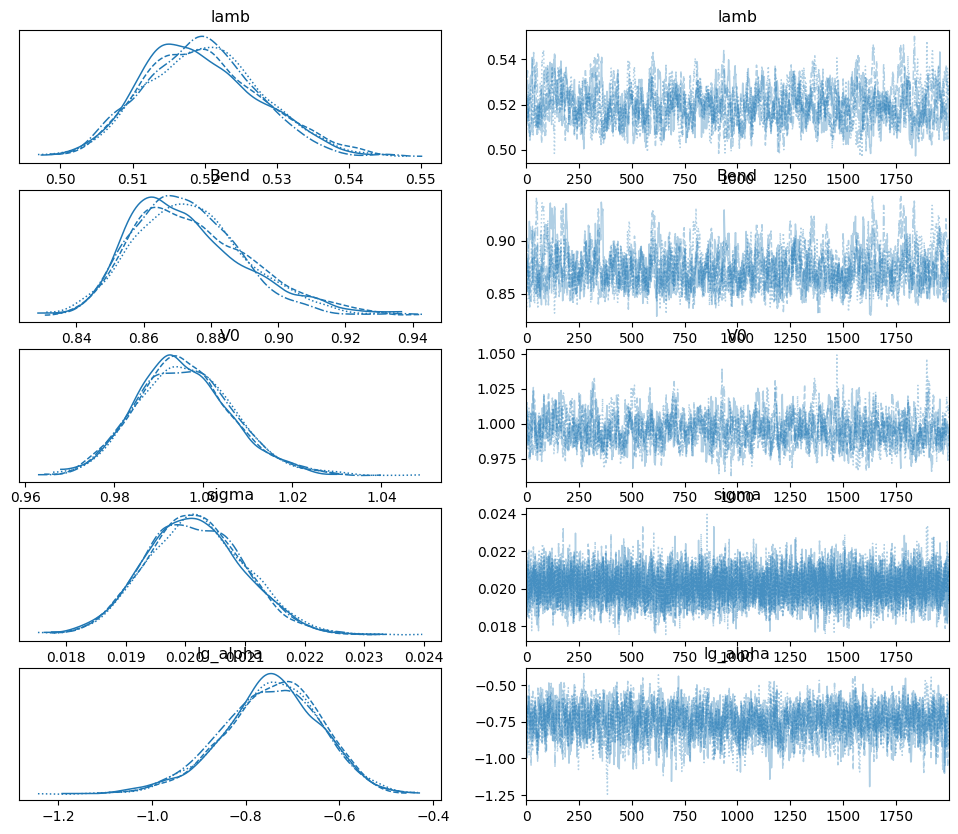

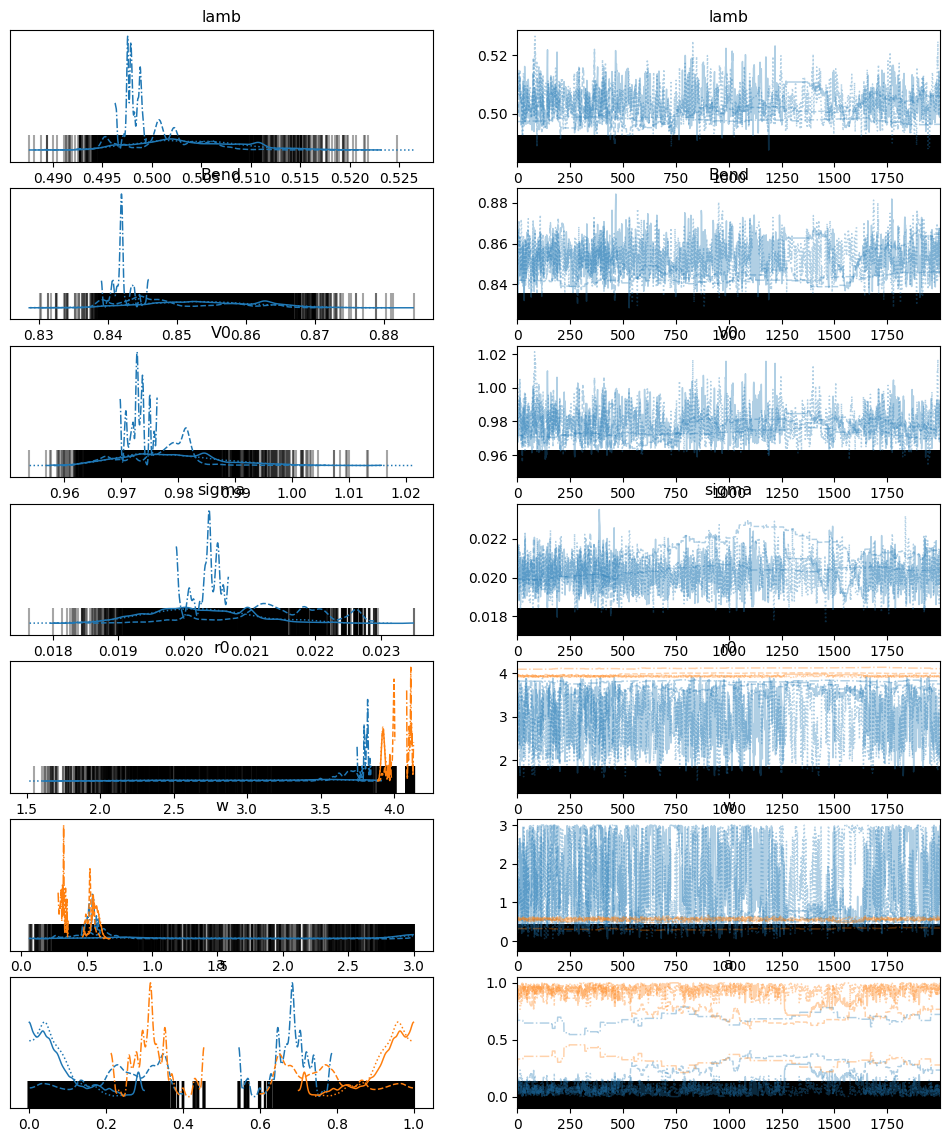

In [12]:
# non-parametric trace is converged:
az.plot_trace(trace_tikh, var_names=["lamb","Bend","V0","sigma","lg_alpha"], combined=False)
# parametric trace is not converged
az.plot_trace(trace_gauss, var_names=["lamb","Bend","V0","sigma","r0","w","a"], combined=False)

It can be seen that the non-parametric trace is well-converged, while the parametric trace is not. This is probably because the sampler does not know where to put the second gaussian in the parametric trace, as shown by the large uncertainties in its mean (`r0`), width (`w`), and amplitude (`a`) on the arviz plot. Changing the model to be a 1-gaussian model would likely help with convergence.

**Question: My chains aren't converged! What should I do?**

**Answer:** Try the following steps:

1. **Increase the number of draws**. Most often, you just need to run your trace for longer to attain convergence.

2. **Increase the number of tunes**. Proper tuning is important to good sampling, and increasing the number of tuning steps may help, though anything above 2000 tunes per chain probably will not be too helpful.

3. **Adjust your model**. For example, shortening the maximum value of the r-axis will lead to faster sampling and convergence. You may also want to consider changing the number of gaussians (if using a parametric model) and changing the resolution of the r-axis.

4. **Prune chain(s)**. If you notice that one (or more) chains are particularly unconverged, but the rest are decent, then you could remove the faulty chain(s). You can do this through `dive.prune_chains(trace)`, which drops each chain one by one and pruning the one that reduces `r_hat` the most, repeating until converged. You can also remove chains with `trace.sel(chain=desired_chain_numbers)`. Note that pruning chains will not be very effective if all of your chains are very different from each other.

5. **Set alpha to a fixed value**. This can be done by passing an `alpha` parameter in `dive.model()`. Removing a parameter may make for better sampling. However, fixing a parameter will also limit the validity of the uncertainty analysis, so do this with caution.

# Accessing Results

**Note: If you are primarily interested in plots of the results, read the Plotting section first.**

The output of `dive.sample()` is an [ArviZ InferenceData object](https://python.arviz.org/en/latest/getting_started/XarrayforArviZ.html#xarray-for-arviz) that consists of three xarray objects: `posterior`, `sample_stats`, and `observed_data`.

In [13]:
print(trace_tikh)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


We are primarily interested in `trace.posterior`, which is an xarray object containing all of our parameters as data variables, the chains and draws as coordinates, and some supplementary information as attributes.

In [14]:
print(trace_tikh.posterior)

<xarray.Dataset> Size: 4MB
Dimensions:   (chain: 4, draw: 2000, P_dim_0: 51)
Coordinates:
  * chain     (chain) int64 32B 0 1 2 3
  * draw      (draw) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * P_dim_0   (P_dim_0) float64 408B 1.5 1.6 1.7 1.8 1.9 ... 6.1 6.2 6.3 6.4 6.5
Data variables:
    Bend      (chain, draw) float64 64kB 0.87 0.8634 0.8776 ... 0.8521 0.8521
    P         (chain, draw, P_dim_0) float64 3MB ...
    V0        (chain, draw) float64 64kB 0.9883 0.9897 0.9849 ... 0.989 0.989
    delta     (chain, draw) float64 64kB ...
    k         (chain, draw) float64 64kB ...
    lamb      (chain, draw) float64 64kB 0.5145 0.5132 0.5156 ... 0.5079 0.5079
    lg_alpha  (chain, draw) float64 64kB -0.7842 -0.8241 ... -0.6949 -0.7014
    lg_delta  (chain, draw) float64 64kB ...
    sigma     (chain, draw) float64 64kB 0.02009 0.02016 ... 0.0199 0.01937
    tau       (chain, draw) float64 64kB ...
Attributes:
    created_at:                 2024-08-12T07:00:21.702460+

The array stores the values for each parameter in the order they were generated, so if we wanted to find the value of `lamb` for the first draw of the first chain, we would print:

In [15]:
print(trace_tikh.posterior.lamb[0][0])

<xarray.DataArray 'lamb' ()> Size: 8B
array(0.51452)
Coordinates:
    chain    int64 8B 0
    draw     int64 8B 0


Oftentimes, however, this is not a very convenient way to access the posterior distributions. Instead, we can use the function [`az.extract()`](https://python.arviz.org/en/latest/api/generated/arviz.extract.html#arviz.extract), which allows us to extract the parameters we want and stack them to combine the `chain` and `draw` dimensions.

In [16]:
import arviz as az
lamb_array = az.extract(trace_tikh, var_names=["lamb"]) # extracts all the value of lambda for all samples and stacks them
print(lamb_array.values) #.values converts the xarray into a numpy array

[0.51451978 0.51319038 0.51560112 ... 0.50790439 0.5078883  0.5078883 ]


We can also use the `num_samples` parameter of `az.extract()` to draw a random sample from the trace:

In [17]:
sample = az.extract(trace_tikh, var_names=["lamb"], num_samples=10, rng=101) # passing an integer to rng will seed the random sampling to give the same results each time
print(sample.values) # np array of 10 random samples of lambda

[0.52138141 0.52371036 0.51773016 0.51416291 0.53384429 0.52139358
 0.51463376 0.50983408 0.50858118 0.51330056]


With an xarray/numpy array of your parameters, you can perform your data analysis as usual. ArviZ may also have useful functions for data analysis, including [`az.hdi`](https://python.arviz.org/en/stable/api/generated/arviz.hdi.html), which calculates the highest density interval (the equivalent of a confidence interval) for some parameter.

In [18]:
lamb_hdi = az.hdi(trace_tikh, hdi_prob=0.95, var_names=["lamb"]) # calculates the 95% highest density interval for lambda
print(lamb_hdi)

<xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    lamb     (hdi) float64 16B 0.5055 0.5362


**More information about InferenceData objects can be found at the page [Working with Inference Data](https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html).**

**Question**: What happened to $k$, $\sigma$, and $\alpha$?

**Answer**: These variables are not used in sampling, but the related variables $B_{\mathrm{end}}$, $\tau$, and $\delta$ are. However, the values for the non-sampled variables are still calculated at every point, and can be accessed the same way as the sampled variables.

# Plotting Results

`dive` provides several useful plots for assessing fit and investigating marginalized posterior distributions. A few are outlined below:

`dive.plot_V()` plots an ensemble of modelled signals to the true signal, along with residuals and a corresponding ensemble of background fits.

Parameters include:
- `trace`: The trace to plot.
- *`ax=None`*: The matplotlib axis to plot on. If none given, a figure and axis will be created.
- *`num_samples=100`*: The number of ensemble members to plot.
- *`rng=0`*: The random number generator seed to use (for consistent results)
- *`show_avg=False`*: Whether or not to plot the average fits for V and B.

While we recommend using ensemble plots for better capture of uncertainty, you can also plot the fits for V and B as a confidence interval through the parameter `hdi`.

/content/dive/dive/plotting.py:309: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  Bhdi = az.hdi(np.asarray(Bs),hdi_prob=0.95).transpose()
/content/dive/dive/plotting.py:311: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  Vhdi = az.hdi(np.asarray(Vs),hdi_prob=0.95).transpose()


<Axes: title={'center': 'time domain and residuals'}, xlabel='$t$ (µs)', ylabel='$V(t)$ (arb. u.)'>

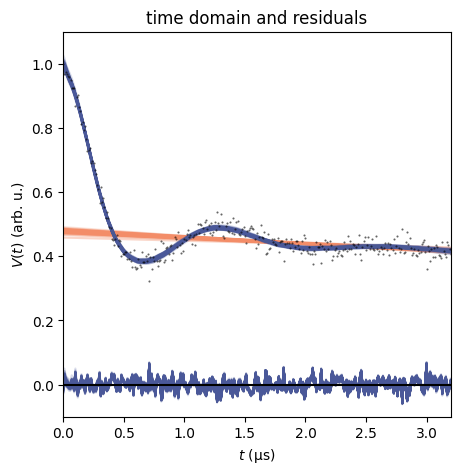

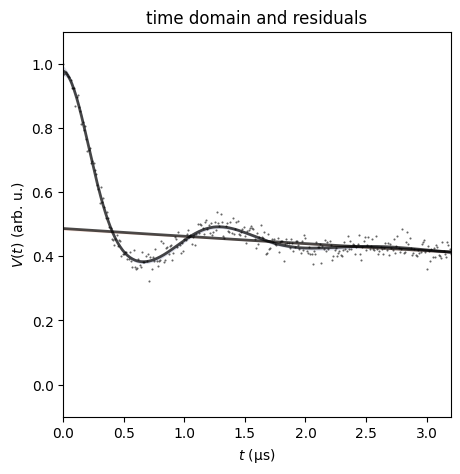

In [19]:
dive.plot_V(trace_tikh)
dive.plot_V(trace_gauss,show_avg=True,hdi=0.95)

`dive.plot_P()` plots an ensemble of distance distributions to give a visualization of the uncertainty of P.

Parameters include:
- `trace`: The trace to plot.
- *`ax=None`*: The matplotlib axis to plot on. If none given, a figure and axis will be created.
- *`num_samples=100`*: The number of ensemble members to plot.
- *`rng=0`*: The random number generator seed to use (for consistent results)
- *`show_avg=False`*: Whether or not to plot the average fit for P.

While we recommend using ensemble plots for better capture of uncertainty, you can also plot the fits for P as a confidence interval through the parameter `hdi`.

/content/dive/dive/plotting.py:399: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  Pci = az.hdi(np.asarray(Ps),hdi_prob=hdi).transpose()


<Axes: title={'center': 'distance domain'}, xlabel='$r$ (nm)', ylabel='$P(r)$ (nm$^{-1}$)'>

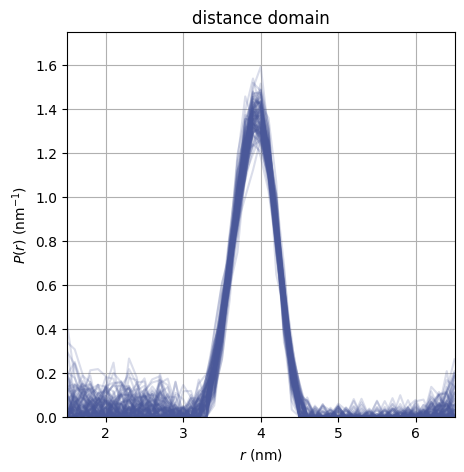

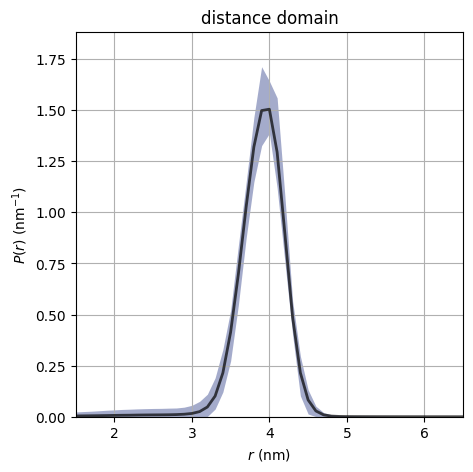

In [20]:
dive.plot_P(trace_tikh)
dive.plot_P(trace_gauss,show_avg=True,hdi=0.95,alpha=0.5)

For the marginal posteriors of the other parameters, you can call `dive.plot_marginals()`.

Parameters of this function include:
- `trace`: The trace to plot the marginalized posteriors from.
- *`axs=None`*: The matplotlib axis to plot the marginalized posteriors on. If none is provided, one will be generated automatically.
- *`var_names=None`*: A list of variables to plot the marginalized posteriors of.
- *`ground_truth=None`*: A dictionary of the true values of the variable names, if known, which will be plotted as a black line on the marginalized posterior plot.

array([<Axes: title={'center': '$λ$'}>,
       <Axes: title={'center': '$B_\\mathrm{end}$'}>,
       <Axes: title={'center': '$V_0$'}>, <Axes: title={'center': '$σ$'}>,
       <Axes: title={'center': '$r_0$'}>, <Axes: title={'center': 'w'}>,
       <Axes: title={'center': 'a'}>], dtype=object)

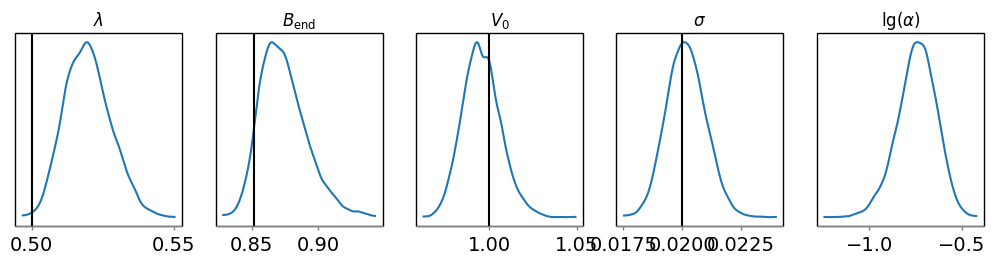

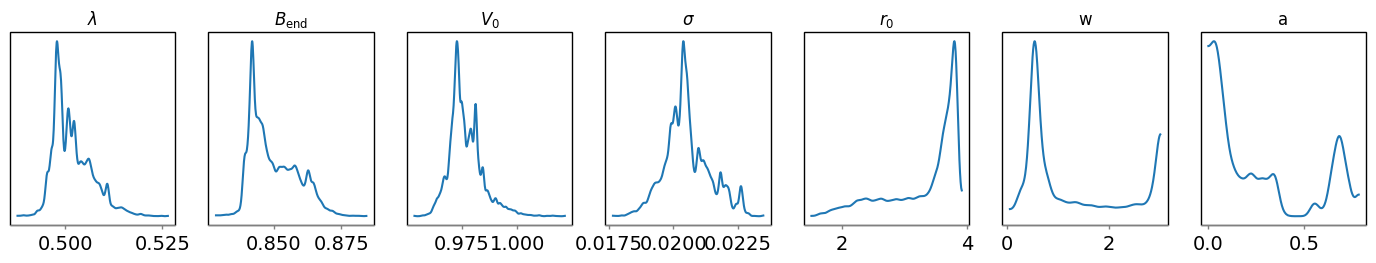

In [21]:
dive.plot_marginals(trace_tikh, var_names=["lamb","Bend","V0","sigma","lg_alpha"], ground_truth={"lamb":0.5,"Bend":np.exp(-0.05*3.2),"V0":1,"sigma":0.02})
dive.plot_marginals(trace_gauss, var_names=["lamb","Bend","V0","sigma","r0","w","a"]) # spiky/uneven plots due to poor convergence

To plot 2-dimensional marginalized posterior plots, which is helpful in investigating correlations between parameters, you can call `dive.plot_correlations()`.

Parameters include:
- `trace`: The trace to plot the marginalized posteriors from.
- *`axs=none`*: The matplotlib axes to plot on. The number of subplots should be consistent with the correlation plot. If none provided, axes will be generated automatically.
- *`var_names=None`*: A list of variables to plot the marginalized posteriors of.
- *`marginals=True`*: Whether or not to plot the 1D marginalized posteriors as well.


array([<Axes: ylabel='$V_0$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: ylabel='$σ$'>,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: ylabel='$r_{0,1}$'>, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: ylabel='$r_{0,2}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: ylabel='$w_1$'>,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: ylabel='$w_2$'>, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: ylabel='$a_1$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: ylabel='$a_2$'>,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >,
       <Axes: xlabel='$λ$', ylabel='$B_\\mathrm{end}$'>,
       

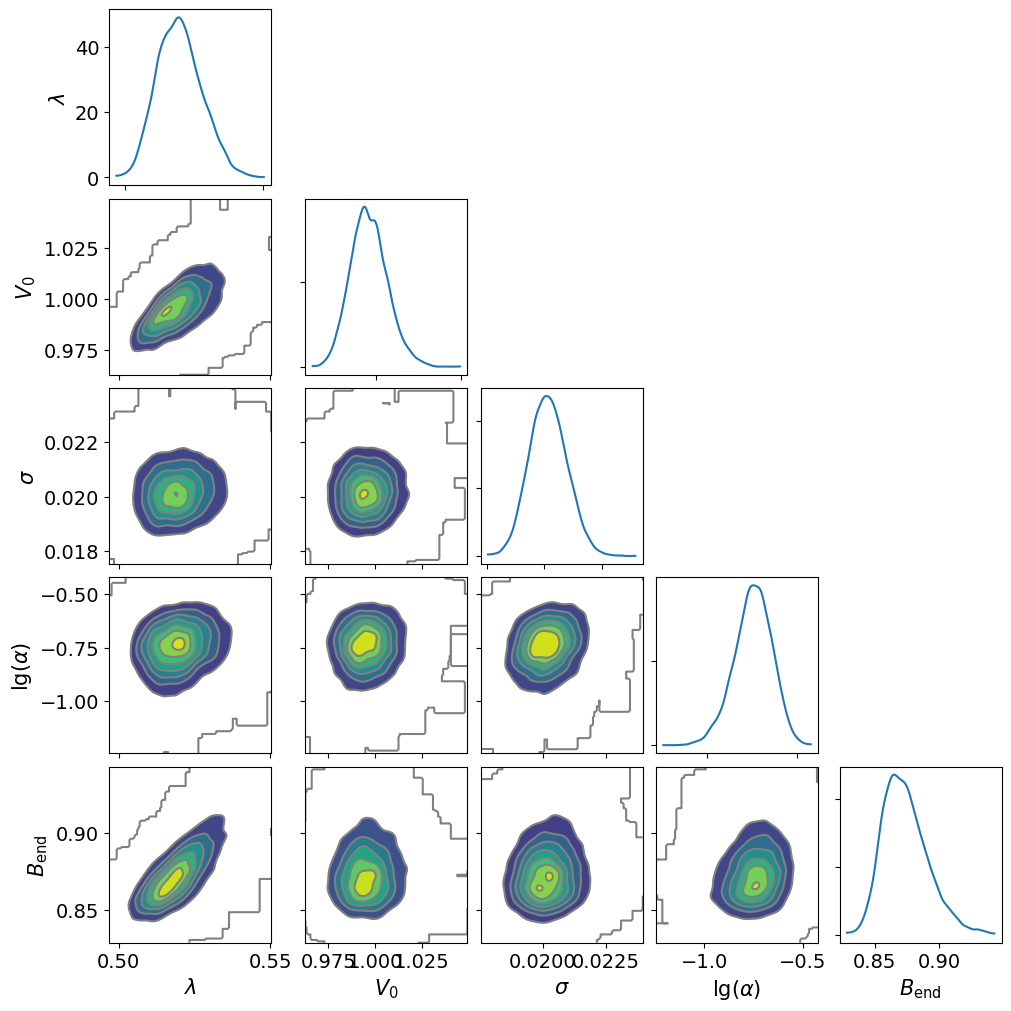

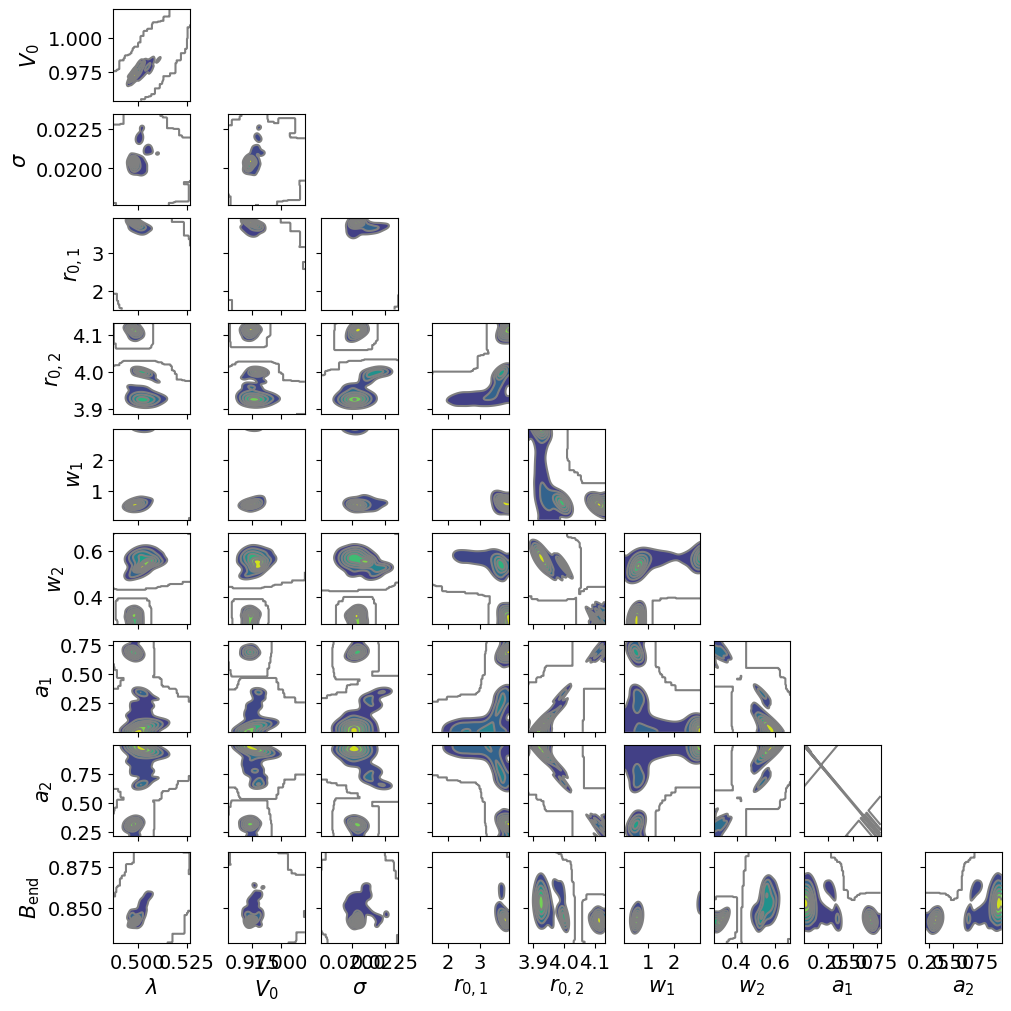

In [22]:
dive.plot_correlations(trace_tikh)
dive.plot_correlations(trace_gauss,marginals=False)